In [1]:
import pandas as pd
from google.colab import drive

# 1. Montar seu Google Drive
# Isso pedirá uma autenticação. Siga as instruções na saída.
drive.mount('/content/drive')



Mounted at /content/drive


In [6]:
# 2. Especificar o caminho do seu arquivo CSV no Google Drive
# Adapte este caminho para o local real do seu arquivo.
# Exemplo: Se seu arquivo está em 'Meu Drive/dados/meu_arquivo.csv'
file_path = '/content/drive/MyDrive/dev/datascienceexp/hr-employee-attrition.csv'

# 3. Ler o arquivo CSV para um DataFrame Pandas
try:
  raw_hr_attr = pd.read_csv(file_path)
except FileNotFoundError:
  print(f"Erro: O arquivo não foi encontrado no caminho especificado: {file_path}")
except Exception as e:
  print(f"Ocorreu um erro ao ler o CSV: {e}")

# Substituir valores nulos por 0 em todo o DataFrame
raw_hr_attr = raw_hr_attr.fillna(0)


In [7]:
# Vamos olhar o conteudo do CSV "soh pra ver mesmo"
raw_hr_attr

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Para um visual mais agradável


# Exemplo de DataFrame Pandas (substitua pelo seu DataFrame real)
data = {
    'MonthlyIncome': [3000, 5000, 2500, 7000, 3500, 6000, 2000, 6500, 3200, 8000],
    'YearsAtCompany': [3, 5, 2, 8, 4, 6, 1, 7, 3, 9],
    'Age': [25, 30, 22, 40, 28, 35, 21, 38, 26, 45]
}
df = pd.DataFrame(data)

def basic_stats(df_pandas, column):
    """
    Calcula e exibe estatísticas básicas (mínimo, máximo, média e mediana)
    para uma coluna numérica em um DataFrame Pandas.

    Args:
        df_pandas (pd.DataFrame): O DataFrame Pandas.
        column (str): O nome da coluna numérica para analisar.
    """
    if column not in df_pandas.columns:
        print(f"Erro: Coluna '{column}' não encontrada no DataFrame.")
        return

    if not pd.api.types.is_numeric_dtype(df_pandas[column]):
        print(f"Erro: Coluna '{column}' não é numérica. Verifique o tipo de dado.")
        return

    # Calcula as estatísticas
    min_val = df_pandas[column].min()
    max_val = df_pandas[column].max()
    avg_val = df_pandas[column].mean()
    median_val = df_pandas[column].median()

    # Cria um dicionário com os resultados
    stats_dict = {
        "Min_" + column: [min_val],
        "Max_" + column: [max_val],
        "Average_" + column: [avg_val],
        "Median_" + column: [median_val]
    }

    # Converte o dicionário para um DataFrame Pandas para um output formatado
    stats_df = pd.DataFrame(stats_dict)

    print(f"Estatísticas para a coluna: '{column}'")
    # Para uma exibição mais limpa no Colab, você pode simplesmente printar o DataFrame
    print(stats_df.round(2).to_string(index=False)) # .to_string(index=False) remove o índice para melhor visualização
    # Ou apenas display(stats_df) se estiver usando notebooks que formatam DataFrames automaticamente

def counting_stats(df_pandas, column, retorna=False, exibe=True):
    """
    Calcula e exibe a contagem e porcentagem de cada categoria em uma coluna
    de um DataFrame Pandas.

    Args:
        df_pandas (pd.DataFrame): O DataFrame Pandas.
        column (str): O nome da coluna categórica para analisar.
        retorna (bool): Se True, retorna o DataFrame de estatísticas.
        exibe (bool): Se True, exibe o DataFrame de estatísticas.

    Returns:
        pd.DataFrame: DataFrame com contagem e porcentagem por categoria, se retorna=True.
    """
    if column not in df_pandas.columns:
        print(f"Erro: Coluna '{column}' não encontrada no DataFrame.")
        return None

    # Calcula a contagem de cada categoria
    conta = df_pandas[column].value_counts().reset_index()
    conta.columns = [column, 'count'] # Renomeia as colunas

    # Calcula a porcentagem
    total_count = df_pandas.shape[0] # Número total de linhas no DataFrame
    conta['percentage'] = round((conta['count'] / total_count) * 100, 2)

    if exibe:
        print(f"Estatísticas de contagem para a coluna: '{column}'")
        print(conta.to_string(index=False)) # Exibe o DataFrame sem o índice

    if retorna:
        return conta
    return None


def plot_perc_relation_chart(df_plot, category_col):
    """
    Plota um gráfico de barras comparando duas porcentagens e uma linha de relação
    para cada categoria em uma coluna.

    Args:
        df_plot (pd.DataFrame): DataFrame contendo as colunas 'perc_1', 'perc_2', 'relation' e a 'category_col'.
        category_col (str): O nome da coluna categórica para o eixo X.
    """
    if not all(col in df_plot.columns for col in [category_col, "perc_1", "perc_2", "relation"]):
        print("Erro: O DataFrame para plotagem deve conter as colunas 'category_col', 'perc_1', 'perc_2', e 'relation'.")
        return

    # Garante que a coluna de categoria seja ordenada para o plot
    pdf = df_plot.sort_values(category_col).copy() # Use .copy() para evitar SettingWithCopyWarning

    fig, ax1 = plt.subplots(figsize=(10, 6)) # Aumentei um pouco o tamanho para melhor visualização

    bar_width = 0.35
    x = range(len(pdf[category_col]))

    # Barras para perc_1 e perc_2
    ax1.bar([i - bar_width/2 for i in x], pdf["perc_1"], width=bar_width, label="Total (%)", color='skyblue', alpha=0.8)
    ax1.bar([i + bar_width/2 for i in x], pdf["perc_2"], width=bar_width, label="Attrition (%)", color='lightcoral', alpha=0.8)
    ax1.set_xlabel(category_col, fontsize=12)
    ax1.set_ylabel("Porcentagem (%)", fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(pdf[category_col], rotation=45, ha='right', fontsize=10) # Rotaciona labels para evitar sobreposição
    ax1.legend(loc="upper left", fontsize=10)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Eixo secundário para a relação
    ax2 = ax1.twinx()
    ax2.plot(x, pdf["relation"], color="darkgreen", marker="o", linestyle='--', linewidth=2, label="Relação (Attrition/Total - 1)*100")
    ax2.set_ylabel("Relação (%) (Atração)", color="darkgreen", fontsize=12)
    ax2.tick_params(axis='y', labelcolor='darkgreen', labelsize=10)
    ax2.legend(loc="upper right", fontsize=10)

    fig.suptitle(f"Comparação de Porcentagem e Relação para {category_col}", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta layout para evitar corte do título
    plt.show()

import pandas as pd
# Não é necessário importar matplotlib.pyplot e seaborn aqui, pois plot_perc_relation_chart já os importa

def compare_stats(df_1_pandas, df_2_pandas, column):
    """
    Compara estatísticas de contagem e porcentagem para uma coluna categórica
    entre dois DataFrames Pandas e plota a relação percentual.

    Args:
        df_1_pandas (pd.DataFrame): O primeiro DataFrame (geralmente a massa total).
        df_2_pandas (pd.DataFrame): O segundo DataFrame (geralmente a massa de Attrition=Yes).
        column (str): O nome da coluna categórica para comparar.
    """
    if column not in df_1_pandas.columns or column not in df_2_pandas.columns:
        print(f"Erro: Coluna '{column}' não encontrada em um ou ambos os DataFrames.")
        return

    # Usar counting_stats para obter as contagens e porcentagens para cada DataFrame
    conta_1 = counting_stats(df_1_pandas, column, retorna=True, exibe=False)
    conta_2 = counting_stats(df_2_pandas, column, retorna=True, exibe=False)


    if conta_1 is None or conta_2 is None:
        print("Não foi possível gerar estatísticas para a comparação.")
        return

    # Juntar os DataFrames de estatísticas usando merge (equivalente ao join outer do Spark)
    joined_df = pd.merge(
        conta_1[[column, 'percentage']], # Seleciona 'index' que é o nome da categoria e 'percentage'
        conta_2[[column, 'percentage']],
        on=column, # Coluna de merge
        how='outer',
        suffixes=('_1', '_2') # Sufixos para colunas de porcentagem
    )

    # Renomear as colunas para o formato esperado pela função de plotagem
    joined_df.rename(columns={'index': column, 'percentage_1': 'perc_1', 'percentage_2': 'perc_2'}, inplace=True)

    # Preencher NaNs com 0 para o cálculo da relação (se uma categoria não existir em um dos DFs)
    joined_df['perc_1'].fillna(0, inplace=True)
    joined_df['perc_2'].fillna(0, inplace=True)

    # Calcular a 'relation'
    # Evitar divisão por zero: se perc_1 for 0, a relação não é definida ou é infinita.
    # Neste caso, podemos definir como 0 ou NaN, dependendo do que faz mais sentido.
    # Para o propósito de exibir o aumento percentual, 0 é mais seguro se não houver base.
    joined_df['relation'] = joined_df.apply(
        lambda row: round(((row['perc_2'] / row['perc_1']) - 1) * 100, 2) if row['perc_1'] != 0 else 0, axis=1
    )

    print(f"\n--- Comparação de Estatísticas para a coluna: '{column}' ---")
    print(joined_df.to_string(index=False))

    # Chamar a função de plotagem
    plot_perc_relation_chart(joined_df, column)



## Variáveis Disponíveis:
- **Demográficas**: Age, Gender, MaritalStatus, Education, EducationField
- **Profissionais**: Department, JobRole, JobLevel, JobInvolvement, YearsAtCompany
- **Compensação**: MonthlyIncome, PercentSalaryHike, StockOptionLevel
- **Satisfação**: JobSatisfaction, EnvironmentSatisfaction, RelationshipSatis-
faction
- **Work-Life**: OverTime, WorkLifeBalance, BusinessTravel, Distance-
FromHome
- **Performance**: PerformanceRating, TrainingTimesLastYear
- **Target**: Attrition (Yes/No)

In [18]:
# Separando em 2 outros DataFrames, um com e outro sem attrition

# Filtrar para funcionários com Attrition 'Yes'
# O .copy() é uma boa prática para evitar o SettingWithCopyWarning,
# que pode ocorrer quando você modifica um sub-DataFrame.
attrition_yes_df = raw_hr_attr[raw_hr_attr["Attrition"] == "Yes"].copy()

# Filtrar para funcionários com Attrition 'No'
attrition_no_df = raw_hr_attr[raw_hr_attr["Attrition"] == "No"].copy()


In [19]:
print("--- DataFrame de Attrition = 'Yes' ---")
attrition_yes_df



--- DataFrame de Attrition = 'Yes' ---


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
14,28,Yes,Travel_Rarely,103,Research & Development,24,3,Life Sciences,1,19,...,2,80,0,6,4,3,4,2,0,3
21,36,Yes,Travel_Rarely,1218,Sales,9,4,Life Sciences,1,27,...,2,80,0,10,4,3,5,3,0,3
24,34,Yes,Travel_Rarely,699,Research & Development,6,1,Medical,1,31,...,3,80,0,8,2,3,4,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,23,Yes,Travel_Frequently,638,Sales,9,3,Marketing,1,2023,...,1,80,1,1,3,2,1,0,1,0
1442,29,Yes,Travel_Rarely,1092,Research & Development,1,4,Medical,1,2027,...,2,80,3,4,3,4,2,2,2,2
1444,56,Yes,Travel_Rarely,310,Research & Development,7,2,Technical Degree,1,2032,...,4,80,1,14,4,1,10,9,9,8
1452,50,Yes,Travel_Frequently,878,Sales,1,4,Life Sciences,1,2044,...,4,80,2,12,3,3,6,3,0,1


In [20]:
print("\n--- DataFrame de Attrition = 'No' ---")
attrition_no_df


--- DataFrame de Attrition = 'No' ---


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,...,3,80,0,8,2,2,7,7,3,6
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,...,1,80,3,12,3,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


In [22]:
counting_stats(raw_hr_attr, "MaritalStatus")

Estatísticas de contagem para a coluna: 'MaritalStatus'
MaritalStatus  count  percentage
      Married    673       45.78
       Single    470       31.97
     Divorced    327       22.24


/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'MaritalStatus' ---
MaritalStatus  perc_1  perc_2  relation
     Divorced   22.24   13.92    -37.41
      Married   45.78   35.44    -22.59
       Single   31.97   50.63     58.37


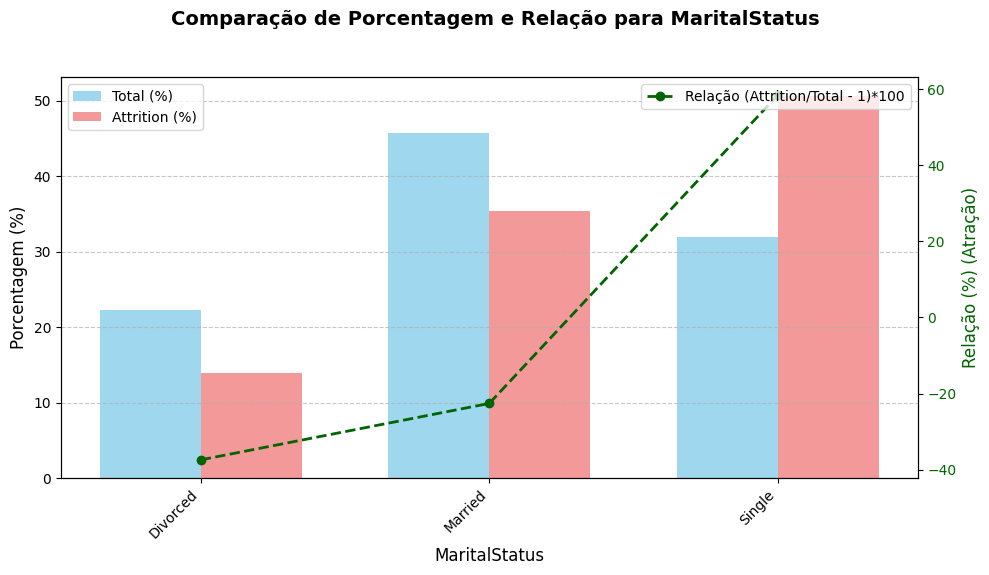

/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'EducationField' ---
  EducationField  perc_1  perc_2  relation
 Human Resources    1.84    2.95     60.33
   Life Sciences   41.22   37.55     -8.90
       Marketing   10.82   14.77     36.51
         Medical   31.56   26.58    -15.78
           Other    5.58    4.64    -16.85
Technical Degree    8.98   13.50     50.33


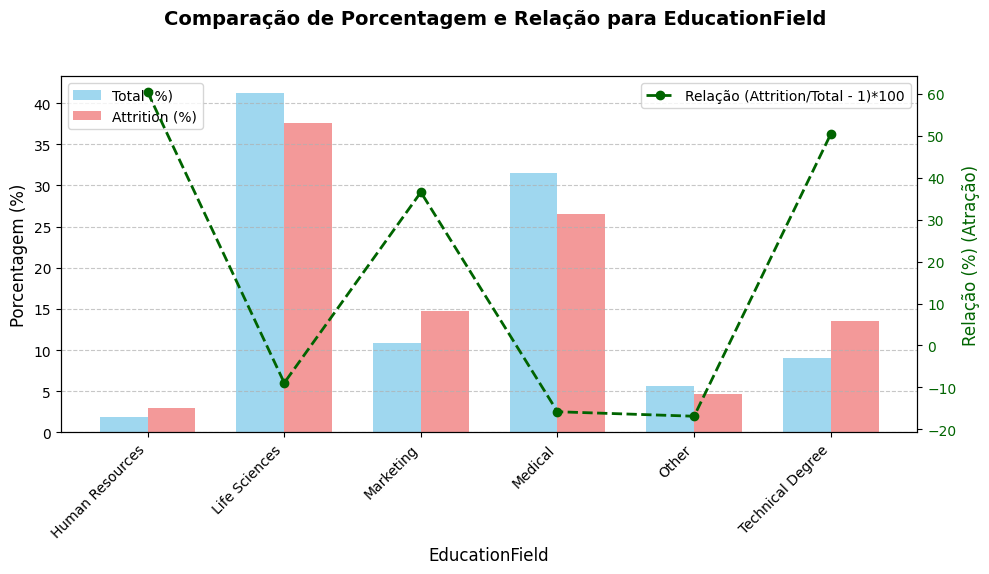

/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'JobRole' ---
                  JobRole  perc_1  perc_2  relation
Healthcare Representative    8.91    3.80    -57.35
          Human Resources    3.54    5.06     42.94
    Laboratory Technician   17.62   26.16     48.47
                  Manager    6.94    2.11    -69.60
   Manufacturing Director    9.86    4.22    -57.20
        Research Director    5.44    0.84    -84.56
       Research Scientist   19.86   19.83     -0.15
          Sales Executive   22.18   24.05      8.43
     Sales Representative    5.65   13.92    146.37


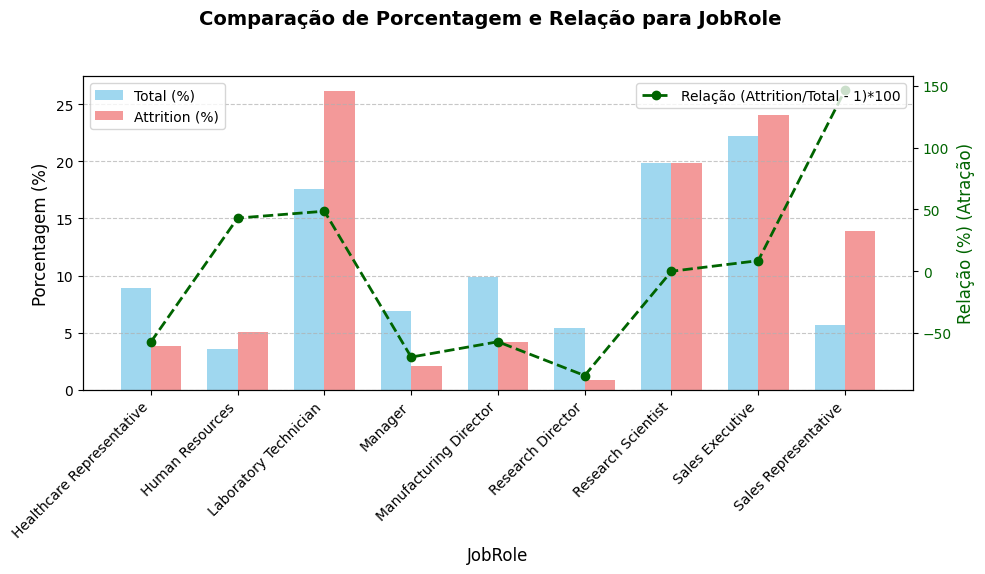

/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'JobLevel' ---
 JobLevel  perc_1  perc_2  relation
        1   36.94   60.34     63.35
        2   36.33   21.94    -39.61
        3   14.83   13.50     -8.97
        4    7.21    2.11    -70.74
        5    4.69    2.11    -55.01


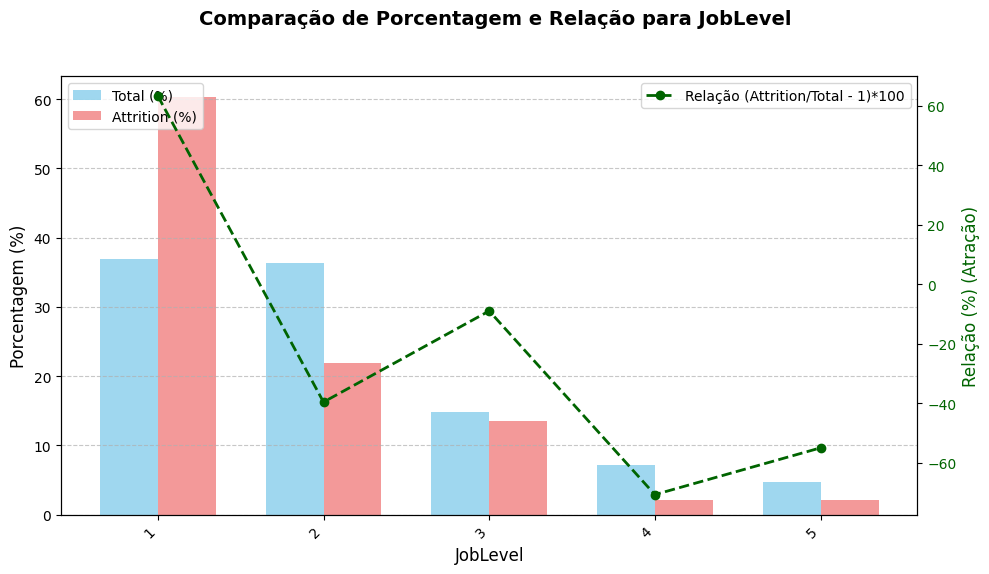

/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'JobInvolvement' ---
 JobInvolvement  perc_1  perc_2  relation
              1    5.65   11.81    109.03
              2   25.51   29.96     17.44
              3   59.05   52.74    -10.69
              4    9.80    5.49    -43.98


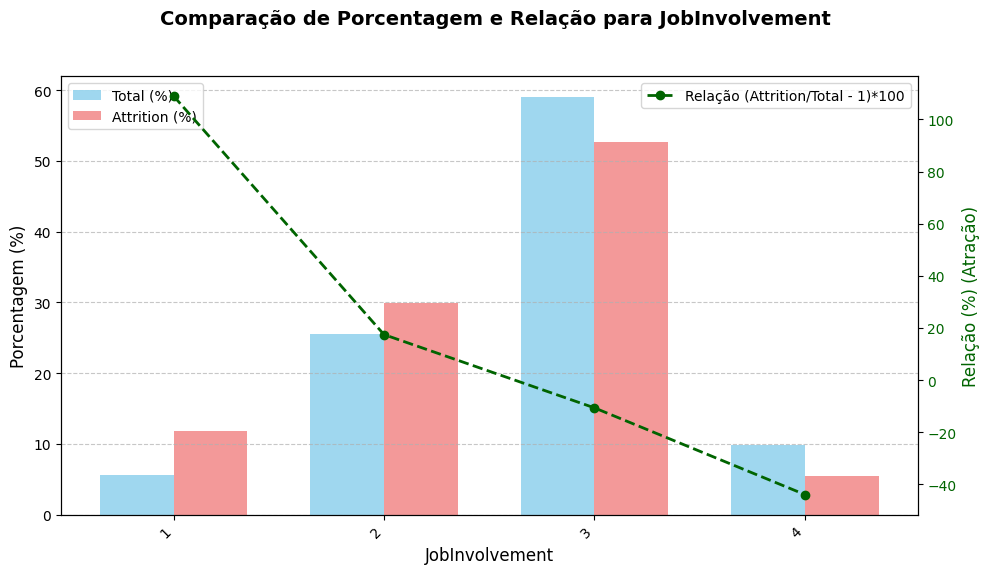

/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'StockOptionLevel' ---
 StockOptionLevel  perc_1  perc_2  relation
                0   42.93   64.98     51.36
                1   40.54   23.63    -41.71
                2   10.75    5.06    -52.93
                3    5.78    6.33      9.52


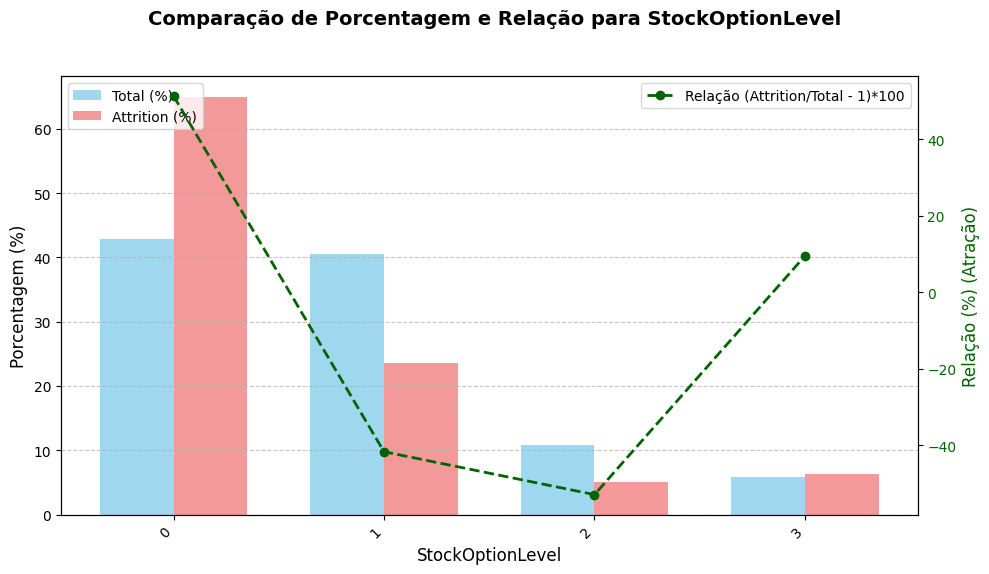

/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'EnvironmentSatisfaction' ---
 EnvironmentSatisfaction  perc_1  perc_2  relation
                       1   19.32   30.38     57.25
                       2   19.52   18.14     -7.07
                       3   30.82   26.16    -15.12
                       4   30.34   25.32    -16.55


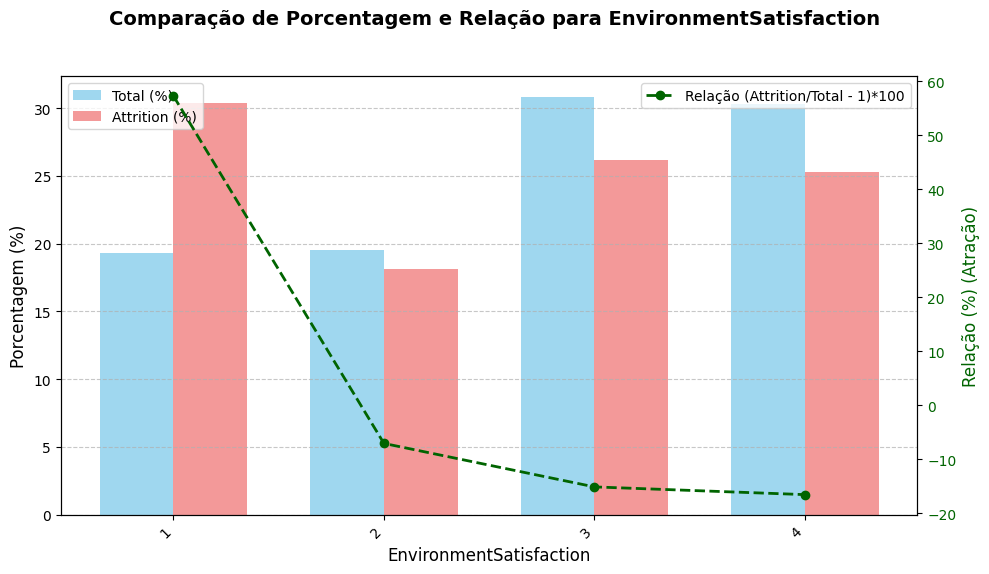

/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'JobSatisfaction' ---
 JobSatisfaction  perc_1  perc_2  relation
               1   19.66   27.85     41.66
               2   19.05   19.41      1.89
               3   30.07   30.80      2.43
               4   31.22   21.94    -29.72


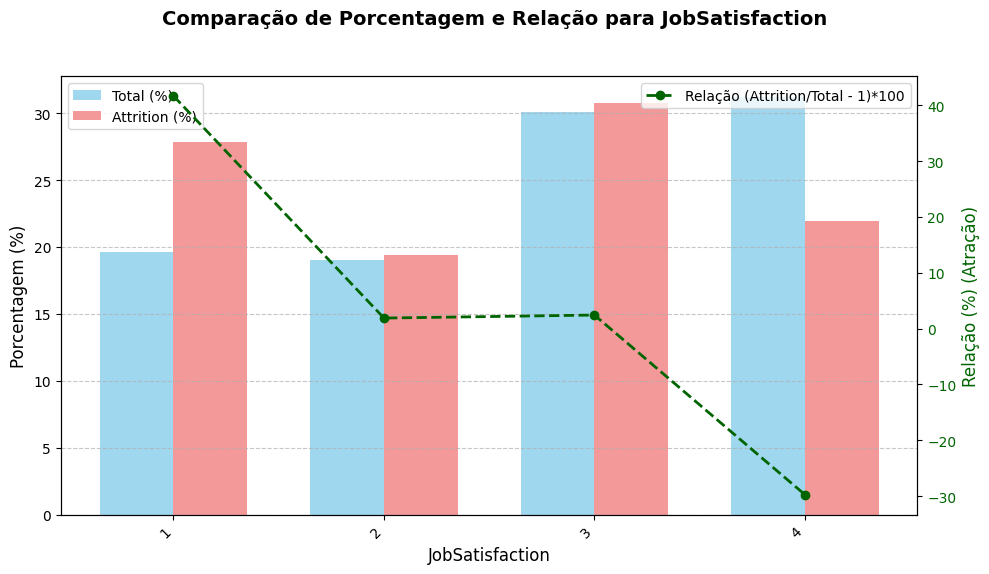

/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'RelationshipSatisfaction' ---
 RelationshipSatisfaction  perc_1  perc_2  relation
                        1   18.78   24.05     28.06
                        2   20.61   18.99     -7.86
                        3   31.22   29.96     -4.04
                        4   29.39   27.00     -8.13


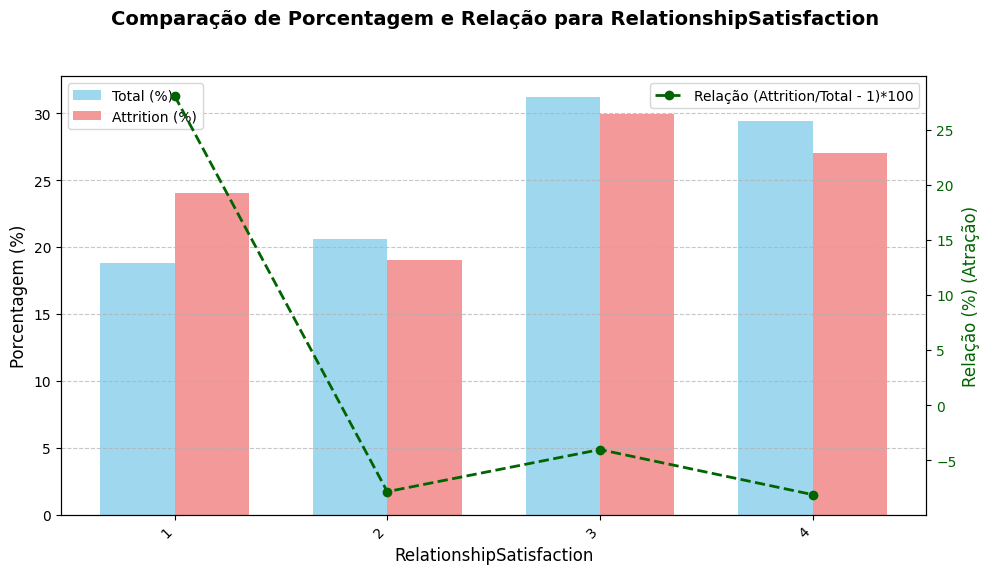

/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'WorkLifeBalance' ---
 WorkLifeBalance  perc_1  perc_2  relation
               1    5.44   10.55     93.93
               2   23.40   24.47      4.57
               3   60.75   53.59    -11.79
               4   10.41   11.39      9.41


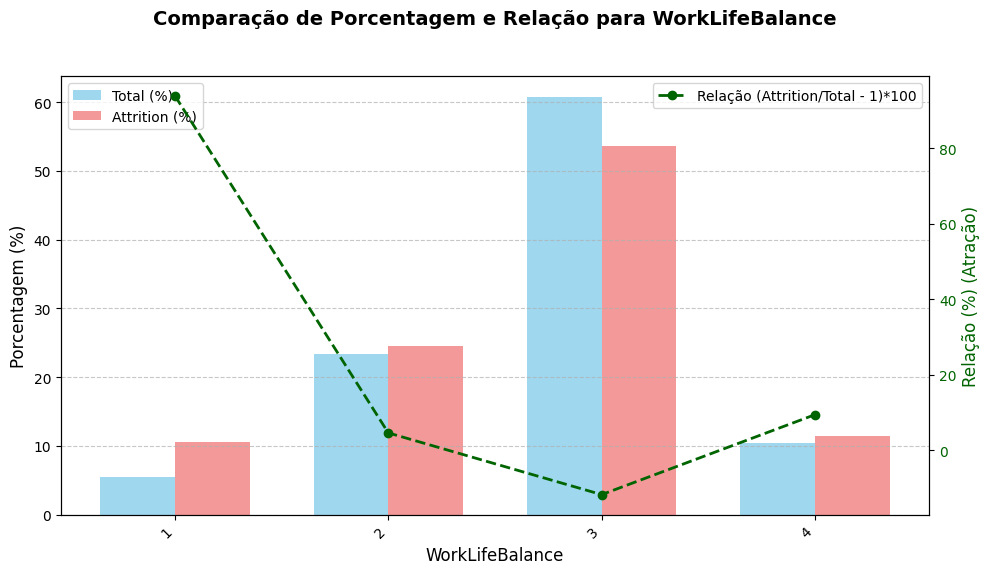

/tmp/ipython-input-23-1214176862.py:169: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df['perc_1'].fillna(0, inplace=True)
/tmp/ipython-input-23-1214176862.py:170: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t


--- Comparação de Estatísticas para a coluna: 'OverTime' ---
OverTime  perc_1  perc_2  relation
      No    71.7   46.41    -35.27
     Yes    28.3   53.59     89.36


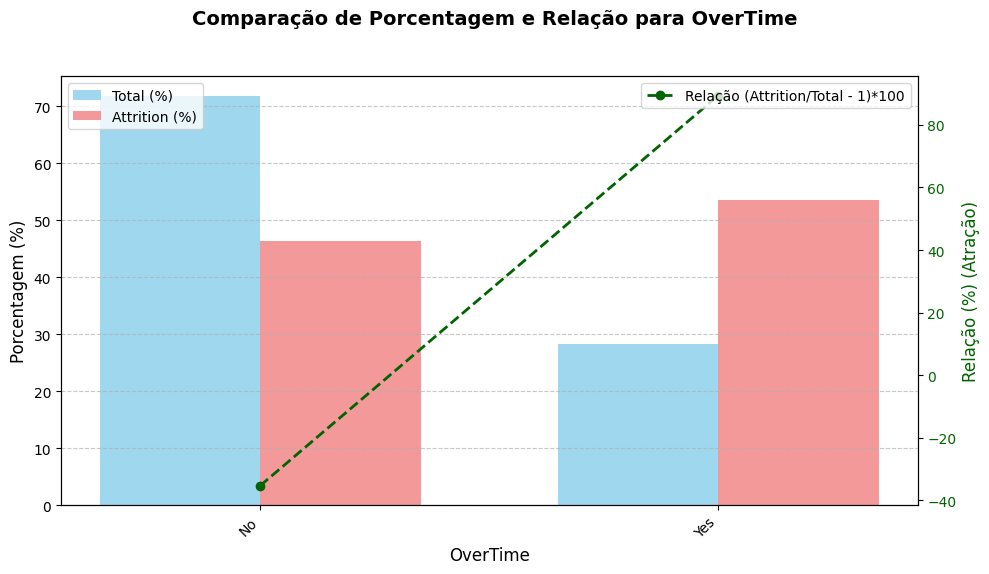

In [24]:
# AquiSantina - com esta funcao se compara os dataframes totais com os com AttritionYes
# para variaves categorica. Estes dois aqui embaixo eis minhas conclusoes :
# Ser Single eh relevante, ficou 50% maior na massa COM atrito
# No EducationField as areas que tem maior aumento sao HR, Marketing e Techinical Degree
compare_stats(raw_hr_attr, attrition_yes_df, "MaritalStatus")
compare_stats(raw_hr_attr, attrition_yes_df, "EducationField")
compare_stats(raw_hr_attr, attrition_yes_df, "JobRole")
compare_stats(raw_hr_attr, attrition_yes_df, "JobLevel")
compare_stats(raw_hr_attr, attrition_yes_df, "JobInvolvement")
compare_stats(raw_hr_attr, attrition_yes_df, "StockOptionLevel")
compare_stats(raw_hr_attr, attrition_yes_df, "EnvironmentSatisfaction")
compare_stats(raw_hr_attr, attrition_yes_df, "JobSatisfaction")
compare_stats(raw_hr_attr, attrition_yes_df, "RelationshipSatisfaction")
compare_stats(raw_hr_attr, attrition_yes_df, "WorkLifeBalance")
compare_stats(raw_hr_attr, attrition_yes_df, "OverTime")


In [ ]:

# Separando as colunas que me interessam para montar as features

selected_columns = [
    "EmployeeNumber",
    "MaritalStatus",
    "JobLevel",
    "JobInvolvement",
    "YearsAtCompany",
    "MonthlyIncome",
    "StockOptionLevel",
    "JobSatisfaction",
    "EnvironmentSatisfaction",
    "OverTime",
    "WorkLifeBalance",
    "Attrition"
]

spark.sql("DROP TABLE IF EXISTS bz_hr_attr_features")

# Criando um nova tabela com as features
raw_hr_attr.select(selected_columns).write.format("delta").mode("overwrite").saveAsTable("bz_hr_attr_features")




# Abaixo está a primeira exploração de dados



1. Comparando grupo por grupo em percentual
2. Depois de olhar cada variavel a exploração que está nas primeiras células e que geram gráficos para melhor comparação
3. Mantivemos para um historico da exploração



In [26]:
# Analise das variaveis demograficas e comparando com attrition yes e no
print("----Age----")
basic_stats(raw_hr_attr, "Age")
basic_stats(attrition_yes_df, "Age")

print("----Gender----")
counting_stats(raw_hr_attr, "Gender")
counting_stats(attrition_yes_df, "Gender")

print("----MaritalStatus----")
counting_stats(raw_hr_attr, "MaritalStatus")
counting_stats(attrition_yes_df, "MaritalStatus")

print("-----Education-----")
counting_stats(raw_hr_attr, "Education")
counting_stats(attrition_yes_df, "Education")

print("----EducationField----")
counting_stats(raw_hr_attr, "EducationField")
counting_stats(attrition_yes_df, "EducationField")


# Analise das variaveis de compensacao
# basic_stats(raw_hr_attr, "DailyRate")
# basic_stats(raw_hr_attr, "MonthlyIncome")
# basic_stats(raw_hr_attr, "MonthlyRate")

----Age----
Estatísticas para a coluna: 'Age'
 Min_Age  Max_Age  Average_Age  Median_Age
      18       60        36.92        36.0
Estatísticas para a coluna: 'Age'
 Min_Age  Max_Age  Average_Age  Median_Age
      18       58        33.61        32.0
----Gender----
Estatísticas de contagem para a coluna: 'Gender'
Gender  count  percentage
  Male    882        60.0
Female    588        40.0
Estatísticas de contagem para a coluna: 'Gender'
Gender  count  percentage
  Male    150       63.29
Female     87       36.71
----MaritalStatus----
Estatísticas de contagem para a coluna: 'MaritalStatus'
MaritalStatus  count  percentage
      Married    673       45.78
       Single    470       31.97
     Divorced    327       22.24
Estatísticas de contagem para a coluna: 'MaritalStatus'
MaritalStatus  count  percentage
       Single    120       50.63
      Married     84       35.44
     Divorced     33       13.92
-----Education-----
Estatísticas de contagem para a coluna: 'Education'
 Educatio

In [27]:
# Analise das variaveis demograficas e comparando com attrition yes e no
# Profissionais: Department, JobRole, JobLevel, JobInvolvement, YearsAtCompany

print("----Department----")
counting_stats(raw_hr_attr, "Department")
counting_stats(attrition_yes_df, "Department")

print("----JobRole----")
counting_stats(raw_hr_attr, "JobRole")
counting_stats(attrition_yes_df, "JobRole")

print("——JobLevel——")
counting_stats(raw_hr_attr, "JobLevel")
counting_stats(attrition_yes_df, "JobLevel")

print("——JobInvolvement——")
counting_stats(raw_hr_attr, "JobInvolvement")
counting_stats(attrition_yes_df, "JobInvolvement")

print("——YearsAtCompany——")
basic_stats(raw_hr_attr, "YearsAtCompany")
basic_stats(attrition_yes_df, "YearsAtCompany")
basic_stats(attrition_no_df, "YearsAtCompany")

# Analise das variaveis de compensacao
# basic_stats(raw_hr_attr, "DailyRate")
# basic_stats(raw_hr_attr, "MonthlyIncome")
# basic_stats(raw_hr_attr, "MonthlyRate")

----Department----
Estatísticas de contagem para a coluna: 'Department'
            Department  count  percentage
Research & Development    961       65.37
                 Sales    446       30.34
       Human Resources     63        4.29
Estatísticas de contagem para a coluna: 'Department'
            Department  count  percentage
Research & Development    133       56.12
                 Sales     92       38.82
       Human Resources     12        5.06
----JobRole----
Estatísticas de contagem para a coluna: 'JobRole'
                  JobRole  count  percentage
          Sales Executive    326       22.18
       Research Scientist    292       19.86
    Laboratory Technician    259       17.62
   Manufacturing Director    145        9.86
Healthcare Representative    131        8.91
                  Manager    102        6.94
     Sales Representative     83        5.65
        Research Director     80        5.44
          Human Resources     52        3.54
Estatísticas de contage

In [28]:
# Compensação: MonthlyIncome, PercentSalaryHike, StockOptionLevel
# Satisfação: JobSatisfaction, EnvironmentSatisfaction, RelationshipSatis- faction
# Work-Life: OverTime, WorkLifeBalance, BusinessTravel, Distance- FromHome
# Performance: PerformanceRating, TrainingTimesLastYear

print("——MonthlyIncome——")
basic_stats(raw_hr_attr, "MonthlyIncome")
basic_stats(attrition_yes_df, "MonthlyIncome")

print("——PercentSalaryHike——")
basic_stats(raw_hr_attr, "PercentSalaryHike")
basic_stats(attrition_yes_df, "PercentSalaryHike")

print("——StockOptionLevel——")
counting_stats(raw_hr_attr, "StockOptionLevel")
counting_stats(attrition_yes_df, "StockOptionLevel")

——MonthlyIncome——
Estatísticas para a coluna: 'MonthlyIncome'
 Min_MonthlyIncome  Max_MonthlyIncome  Average_MonthlyIncome  Median_MonthlyIncome
              1009              19999                6502.93                4919.0
Estatísticas para a coluna: 'MonthlyIncome'
 Min_MonthlyIncome  Max_MonthlyIncome  Average_MonthlyIncome  Median_MonthlyIncome
              1009              19859                4787.09                3202.0
——PercentSalaryHike——
Estatísticas para a coluna: 'PercentSalaryHike'
 Min_PercentSalaryHike  Max_PercentSalaryHike  Average_PercentSalaryHike  Median_PercentSalaryHike
                    11                     25                      15.21                      14.0
Estatísticas para a coluna: 'PercentSalaryHike'
 Min_PercentSalaryHike  Max_PercentSalaryHike  Average_PercentSalaryHike  Median_PercentSalaryHike
                    11                     25                       15.1                      14.0
——StockOptionLevel——
Estatísticas de contagem pa

In [29]:
# Satisfação: JobSatisfaction, EnvironmentSatisfaction, RelationshipSatis- faction
# Work-Life: OverTime, WorkLifeBalance, BusinessTravel, Distance- FromHome
# Performance: PerformanceRating, TrainingTimesLastYear

print("——JobSatisfaction——")
counting_stats(raw_hr_attr, "JobSatisfaction")
counting_stats(attrition_yes_df, "JobSatisfaction")

print("——EnvironmentSatisfaction——")
counting_stats(raw_hr_attr, "EnvironmentSatisfaction")
counting_stats(attrition_yes_df, "EnvironmentSatisfaction")

print("——RelationshipSatisfaction——")
counting_stats(raw_hr_attr, "RelationshipSatisfaction")
counting_stats(attrition_yes_df, "RelationshipSatisfaction")

——JobSatisfaction——
Estatísticas de contagem para a coluna: 'JobSatisfaction'
 JobSatisfaction  count  percentage
               4    459       31.22
               3    442       30.07
               1    289       19.66
               2    280       19.05
Estatísticas de contagem para a coluna: 'JobSatisfaction'
 JobSatisfaction  count  percentage
               3     73       30.80
               1     66       27.85
               4     52       21.94
               2     46       19.41
——EnvironmentSatisfaction——
Estatísticas de contagem para a coluna: 'EnvironmentSatisfaction'
 EnvironmentSatisfaction  count  percentage
                       3    453       30.82
                       4    446       30.34
                       2    287       19.52
                       1    284       19.32
Estatísticas de contagem para a coluna: 'EnvironmentSatisfaction'
 EnvironmentSatisfaction  count  percentage
                       1     72       30.38
                       3     62     

In [30]:
# Work-Life: OverTime, WorkLifeBalance, BusinessTravel, Distance- FromHome
# Performance: PerformanceRating, TrainingTimesLastYear

print("——OverTime——")
counting_stats(raw_hr_attr, "OverTime")
counting_stats(attrition_yes_df, "OverTime")

print("——WorkLifeBalance——")
counting_stats(raw_hr_attr, "WorkLifeBalance")
counting_stats(attrition_yes_df, "WorkLifeBalance")

print("——BusinessTravel——")
counting_stats(raw_hr_attr, "BusinessTravel")
counting_stats(attrition_yes_df, "BusinessTravel")

print("——DistanceFromHome——")
basic_stats(raw_hr_attr, "DistanceFromHome")
basic_stats(attrition_yes_df, "DistanceFromHome")

——OverTime——
Estatísticas de contagem para a coluna: 'OverTime'
OverTime  count  percentage
      No   1054        71.7
     Yes    416        28.3
Estatísticas de contagem para a coluna: 'OverTime'
OverTime  count  percentage
     Yes    127       53.59
      No    110       46.41
——WorkLifeBalance——
Estatísticas de contagem para a coluna: 'WorkLifeBalance'
 WorkLifeBalance  count  percentage
               3    893       60.75
               2    344       23.40
               4    153       10.41
               1     80        5.44
Estatísticas de contagem para a coluna: 'WorkLifeBalance'
 WorkLifeBalance  count  percentage
               3    127       53.59
               2     58       24.47
               4     27       11.39
               1     25       10.55
——BusinessTravel——
Estatísticas de contagem para a coluna: 'BusinessTravel'
   BusinessTravel  count  percentage
    Travel_Rarely   1043       70.95
Travel_Frequently    277       18.84
       Non-Travel    150       10.

In [31]:
# Performance: PerformanceRating, TrainingTimesLastYear

print("——PerformanceRating——")
counting_stats(raw_hr_attr, "PerformanceRating")
counting_stats(attrition_yes_df, "PerformanceRating")

print("——TrainingTimesLastYear——")
counting_stats(raw_hr_attr, "TrainingTimesLastYear")
counting_stats(attrition_yes_df, "TrainingTimesLastYear")



——PerformanceRating——
Estatísticas de contagem para a coluna: 'PerformanceRating'
 PerformanceRating  count  percentage
                 3   1244       84.63
                 4    226       15.37
Estatísticas de contagem para a coluna: 'PerformanceRating'
 PerformanceRating  count  percentage
                 3    200       84.39
                 4     37       15.61
——TrainingTimesLastYear——
Estatísticas de contagem para a coluna: 'TrainingTimesLastYear'
 TrainingTimesLastYear  count  percentage
                     2    547       37.21
                     3    491       33.40
                     4    123        8.37
                     5    119        8.10
                     1     71        4.83
                     6     65        4.42
                     0     54        3.67
Estatísticas de contagem para a coluna: 'TrainingTimesLastYear'
 TrainingTimesLastYear  count  percentage
                     2     98       41.35
                     3     69       29.11
              

In [33]:
import pandas as pd
import numpy as np # Para usar np.select


# --- 1. Análise inicial de Gender ---
# Agrupar por "Gender" e contar
grouped_attrition_yes_gender = attrition_yes_df['Gender'].value_counts().reset_index()
grouped_attrition_yes_gender.columns = ['Gender', 'count'] # Renomear colunas para clareza

print("--- Contagem por Gênero (Attrition = Yes) ---")
print(grouped_attrition_yes_gender.to_string(index=False))
print("\n")


# --- 2. Criar e Agrupar por Faixa Etária (AgeGroup) ---
# Definir os limites e rótulos para as faixas etárias
bins_age = [0, 20, 26, 30, 40, 50, 60, np.inf] # np.inf para o último limite aberto
labels_age = ["0-19", "20-25", "26-29", "30-39", "40-49", "50-59", "60+"] # Ajustado para corresponder aos seus limites

# Criar a nova coluna 'AgeGroup' usando pd.cut
attrition_yes_df['AgeGroup'] = pd.cut(
    attrition_yes_df['Age'],
    bins=bins_age,
    labels=labels_age,
    right=False # Definir se o intervalo inclui o limite superior (False = [inclusivo, exclusivo))
)

# Agrupar por "AgeGroup" e contar
grouped_attrition_yes_age_group = attrition_yes_df['AgeGroup'].value_counts().reset_index()
grouped_attrition_yes_age_group.columns = ['AgeGroup', 'count']

# Garantir a ordem das faixas etárias
# pd.CategoricalDtype pode ser usado para definir uma ordem explícita
age_group_cat_type = pd.CategoricalDtype(categories=labels_age, ordered=True)
grouped_attrition_yes_age_group['AgeGroup'] = grouped_attrition_yes_age_group['AgeGroup'].astype(age_group_cat_type)
grouped_attrition_yes_age_group = grouped_attrition_yes_age_group.sort_values(by='AgeGroup')


# Calcular a porcentagem
total_count_age = grouped_attrition_yes_age_group['count'].sum() # Soma total das contagens
grouped_attrition_yes_age_group['Percentage'] = round((grouped_attrition_yes_age_group['count'] / total_count_age) * 100, 2)


print("--- Contagem e Porcentagem por Faixa Etária (Attrition = Yes) ---")
print(grouped_attrition_yes_age_group.to_string(index=False))
print("\n")


# --- 3. Criar e Agrupar por Distância de Casa (DistanceFromHomeGroup) ---
# Definir os limites e rótulos para as faixas de distância
bins_distance = [0, 10, 20, np.inf] # np.inf para o último limite aberto
labels_distance = ["0-9", "10-19", "20+"] # Ajustado para corresponder aos seus limites

# Criar a nova coluna 'DistanceFromHomeGroup'
attrition_yes_df['DistanceFromHomeGroup'] = pd.cut(
    attrition_yes_df['DistanceFromHome'],
    bins=bins_distance,
    labels=labels_distance,
    right=False # Definir se o intervalo inclui o limite superior (False = [inclusivo, exclusivo))
)

# Agrupar por "DistanceFromHomeGroup" e contar
grouped_attrition_yes_dst_group = attrition_yes_df['DistanceFromHomeGroup'].value_counts().reset_index()
grouped_attrition_yes_dst_group.columns = ['DistanceFromHomeGroup', 'count']

# Garantir a ordem das faixas de distância
dst_group_cat_type = pd.CategoricalDtype(categories=labels_distance, ordered=True)
grouped_attrition_yes_dst_group['DistanceFromHomeGroup'] = grouped_attrition_yes_dst_group['DistanceFromHomeGroup'].astype(dst_group_cat_type)
grouped_attrition_yes_dst_group = grouped_attrition_yes_dst_group.sort_values(by='DistanceFromHomeGroup')


# Calcular a porcentagem
total_count_dst = grouped_attrition_yes_dst_group['count'].sum()
grouped_attrition_yes_dst_group['Percentage'] = round((grouped_attrition_yes_dst_group['count'] / total_count_dst) * 100, 2)


print("--- Contagem e Porcentagem por Distância de Casa (Attrition = Yes) ---")
print(grouped_attrition_yes_dst_group.to_string(index=False))
print("\n")


# --- 4. Análise de Satisfação com o Trabalho (JobSatisfaction) ---
# Agrupar por "JobSatisfaction" e contar
grouped_attrition_yes_jobsat = attrition_yes_df['JobSatisfaction'].value_counts().reset_index()
grouped_attrition_yes_jobsat.columns = ['JobSatisfaction', 'count']

# Ordenar por JobSatisfaction (já é numérico, então a ordem padrão funciona)
grouped_attrition_yes_jobsat = grouped_attrition_yes_jobsat.sort_values(by='JobSatisfaction', ascending=True)

# Calcular a porcentagem
total_count_jobsat = grouped_attrition_yes_jobsat['count'].sum()
grouped_attrition_yes_jobsat['Percentage'] = round((grouped_attrition_yes_jobsat['count'] / total_count_jobsat) * 100, 2)


print("--- Contagem e Porcentagem por Satisfação com o Trabalho (Attrition = Yes) ---")
print(grouped_attrition_yes_jobsat.to_string(index=False))
print("\n")

--- Contagem por Gênero (Attrition = Yes) ---
Gender  count
  Male    150
Female     87


--- Contagem e Porcentagem por Faixa Etária (Attrition = Yes) ---
AgeGroup  count  Percentage
    0-19     10        4.22
   20-25     34       14.35
   26-29     47       19.83
   30-39     89       37.55
   40-49     34       14.35
   50-59     23        9.70
     60+      0        0.00


--- Contagem e Porcentagem por Distância de Casa (Attrition = Yes) ---
DistanceFromHomeGroup  count  Percentage
                  0-9    133       56.12
                10-19     55       23.21
                  20+     49       20.68


--- Contagem e Porcentagem por Satisfação com o Trabalho (Attrition = Yes) ---
 JobSatisfaction  count  Percentage
               1     66       27.85
               2     46       19.41
               3     73       30.80
               4     52       21.94




In [34]:
import pandas as pd
import numpy as np # Para np.inf e np.select/pd.cut

# RECRIAÇÃO DE DistanceFromHomeGroup para garantir que o código funcione
# Definir os limites e rótulos para as faixas de distância (usando as do seu código anterior)
bins_distance = [0, 10, 20, np.inf]
labels_distance = ["0-9", "10-19", "20+"]

attrition_yes_df['DistanceFromHomeGroup'] = pd.cut(
    attrition_yes_df['DistanceFromHome'],
    bins=bins_distance,
    labels=labels_distance,
    right=False # [inclusivo, exclusivo)
)


# --- 1. Filtrar o DataFrame para DistanceFromHomeGroup igual a "0-10" ---
filtered_df = attrition_yes_df[attrition_yes_df["DistanceFromHomeGroup"] == "0-9"].copy() # Note a mudança para "0-9" devido aos labels definidos acima

print("--- DataFrame Filtrado por DistanceFromHomeGroup = '0-9' (Head) ---")
print(filtered_df.head().to_string())
print("\n")

# --- 2. Criar uma coluna que calcula o AnnualBonus ---
# As colunas MonthlyRate e MonthlyIncome devem existir no filtered_df
filtered_df['AnnualBonus'] = (filtered_df['MonthlyRate'] * 12) - (filtered_df['MonthlyIncome'] * 12)


# --- 3. Calcular estatísticas de AnnualBonus ---
annual_bonus_stats_dict = {
    "MaxAnnualBonus": [filtered_df['AnnualBonus'].max()],
    "MinAnnualBonus": [filtered_df['AnnualBonus'].min()],
    "AvgAnnualBonus": [filtered_df['AnnualBonus'].mean()],
    "MedianAnnualBonus": [filtered_df['AnnualBonus'].median()]
}
annual_bonus_stats = pd.DataFrame(annual_bonus_stats_dict)

print("--- Estatísticas de AnnualBonus para o DataFrame Filtrado ---")
print(annual_bonus_stats.round(2).to_string(index=False))
print("\n")


# --- 4. Criar bins (faixas) para AnnualBonus ---
# bin_edges = [0, 50000, 100000, 150000, 200000, 250000, 300000] # Seus bins originais
# Ajustando os rótulos para melhor corresponder aos seus limites e ao pd.cut
bins_annual_bonus = [0, 50000, 100000, 150000, 200000, 250000, np.inf]
labels_annual_bonus = ["0-49,999", "50k-99,999", "100k-149,999", "150k-199,999", "200k-249,999", ">=250k"]

filtered_df['AnnualBonusBin'] = pd.cut(
    filtered_df['AnnualBonus'],
    bins=bins_annual_bonus,
    labels=labels_annual_bonus,
    right=False, # [inclusivo, exclusivo)
    include_lowest=True # Inclui o menor valor no primeiro bin
)

# --- 5. Agrupar por AnnualBonusBin e contar

--- DataFrame Filtrado por DistanceFromHomeGroup = '0-9' (Head) ---
    Age Attrition BusinessTravel  DailyRate              Department  DistanceFromHome  Education    EducationField  EmployeeCount  EmployeeNumber  EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel                JobRole  JobSatisfaction MaritalStatus  MonthlyIncome  MonthlyRate  NumCompaniesWorked Over18 OverTime  PercentSalaryHike  PerformanceRating  RelationshipSatisfaction  StandardHours  StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager AgeGroup DistanceFromHomeGroup
0    41       Yes  Travel_Rarely       1102                   Sales                 1          2     Life Sciences              1               1                        2  Female          94               3         2        Sales Executive                4        Single           5993        19479                   8      Y  

In [ ]:
from pyspark.sql.functions import sum as sum_, col, round
from pyspark.sql.functions import max as max_, min as min_, avg, expr

# Filter the DataFrame for DistanceFromHomeGroup equals to "0-10"
filtered_df = attrition_yes_df.filter(col("DistanceFromHomeGroup") == "0-10")

# Create a column that calculates the AnnualBonus
filtered_df = filtered_df.withColumn("AnnualBonus", (col("MonthlyRate") * 12 - col("MonthlyIncome") * 12))


annual_bonus_stats = filtered_df.agg(
    max_("AnnualBonus").alias("MaxAnnualBonus"),
    min_("AnnualBonus").alias("MinAnnualBonus"),
    avg("AnnualBonus").alias("AvgAnnualBonus"),
    expr("percentile_approx(AnnualBonus, 0.5)").alias("MedianAnnualBonus")
)

display(filtered_df)
display(annual_bonus_stats)

# Create histogram bins for AnnualBonus (6 layers, max value 120000)
bin_edges = [0, 50000, 100000, 150000, 200000, 250000, 300000]

filtered_df = filtered_df.withColumn(
    "AnnualBonusBin",
    when(col("AnnualBonus") < bin_edges[1], "-0")
    .when((col("AnnualBonus") >= bin_edges[1]) & (col("AnnualBonus") < bin_edges[2]), "-50k")
    .when((col("AnnualBonus") >= bin_edges[2]) & (col("AnnualBonus") < bin_edges[3]), "50k-100k")
    .when((col("AnnualBonus") >= bin_edges[3]) & (col("AnnualBonus") < bin_edges[4]), "100k-150k")
    .when((col("AnnualBonus") >= bin_edges[4]) & (col("AnnualBonus") < bin_edges[5]), "200k-250k")
    .otherwise(">250k")
)

annual_bonus_histogram = (
    filtered_df.groupBy("AnnualBonusBin")
    .count()
    .orderBy("AnnualBonusBin")
)

display(annual_bonus_histogram)

marital_status_counts = filtered_df.groupBy("MaritalStatus").count().orderBy("count", ascending=False)
display(marital_status_counts)